In [1]:
# pip install wordcloud
# pip install textblob

import os
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from nltk.tokenize.toktok import ToktokTokenizer
from bs4 import BeautifulSoup
import spacy
import re,string,unicodedata
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Embedding, LSTM, Dropout, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from textblob import TextBlob
from textblob import Word
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings('ignore')

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    print("Name:", gpu.name, "  Type:", gpu.device_type)

Name: /physical_device:GPU:0   Type: GPU


In [3]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [4]:
data = pd.read_excel('RedditDataSentimental.xlsx')
data.head()

,Sentence,Sentiment,Sentiment Encoding,Suicidal
0,Ask Reddit: I have a massive list of e-mails I...,Negative,2,No
1,Ask Reddit: What's the best piece of trivia th...,Negative,2,No
2,Basketball coach forced to resign because she ...,Positive,1,No
3,Is this the most optimal way to draw the First...,Netural,0,No
4,Can we get some sort of directory style organi...,Netural,0,No


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87267 entries, 0 to 87266
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Sentence            87249 non-null  object
 1   Sentiment           87267 non-null  object
 2   Sentiment Encoding  87267 non-null  int64 
 3   Suicidal            87267 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.7+ MB


In [6]:
data.groupby('Suicidal').size().reset_index(name='counts')

,Suicidal,counts
0,No,80631
1,Yes,6636


<AxesSubplot:xlabel='Suicidal', ylabel='count'>

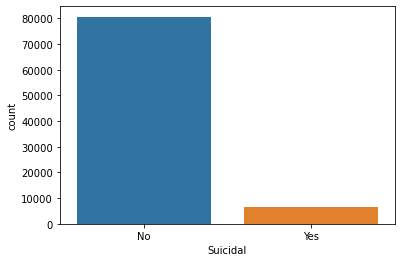

In [7]:
sns.countplot(x=data['Suicidal'])

<AxesSubplot:ylabel='Suicidal'>

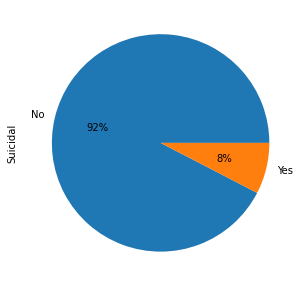

In [8]:
data['Suicidal'].value_counts().plot(kind='pie', autopct='%1.0f%%',figsize=(5,5))

In [9]:
data.duplicated().sum()

15

In [10]:
data= data.drop_duplicates()
data = data.dropna(axis = 0)

In [11]:
#Removing the html strips
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

#Removing the noisy text
def remove_noise(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    return text

#Apply function on text column
data['cleaned']=data['Sentence'].apply(remove_noise)

In [12]:
replace_list = {r"i'm": 'i am',
                r"'re": ' are',
                r"let’s": 'let us',
                r"'s":  ' is',
                r"'ve": ' have',
                r"can't": 'can not',
                r"cannot": 'can not',
                r"shan’t": 'shall not',
                r"n't": ' not',
                r"'d": ' would',
                r"'ll": ' will',
                r"'scuse": 'excuse',
                ',': ' ,',
                '.': ' .',
                '!': ' !',
                '?': ' ?',
                '\s+': ' '}

def clean_text(text):
    text = text.lower()
    for s in replace_list:
        text = text.replace(s, replace_list[s])
    text = ' '.join(text.split())
    return text

data['cleaned']=data['cleaned'].apply(clean_text)

In [13]:
#Define function for removing special characters
def remove_special_characters(text, remove_digits=True):
    pattern=r'[^a-zA-z0-9\s]'
    text=re.sub(pattern,'',text)
    return text

#Apply function on cleaned column
data['cleaned']=data['cleaned'].apply(remove_special_characters)

In [14]:
#Stemming the text
def simple_stemmer(text):
    ps=nltk.porter.PorterStemmer()
    text= ' '.join([ps.stem(word) for word in text.split()])
    return text

#Apply function on cleaned column
data['cleaned']=data['cleaned'].apply(simple_stemmer)

In [15]:
#set stopwords to english

nltk.download('stopwords')
#Tokenization of text
tokenizer=ToktokTokenizer()
#Setting English stopwords
stopword_list=nltk.corpus.stopwords.words('english')

stop=set(stopwords.words('english'))
print(stop)

#removing the stopwords
def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text

#Apply function on cleaned column
data['cleaned']=data['cleaned'].apply(remove_stopwords)

[nltk_data] Downloading package stopwords to C:\Users\Afrime
[nltk_data]     Araf\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


{'a', 'any', 'wasn', 'these', 'between', "needn't", 'for', 'did', 'just', 'during', "shan't", 'couldn', 'mustn', 'when', "doesn't", 'not', 'can', "couldn't", 'his', 'other', 'hasn', 'doing', 'very', 'weren', 'don', 'here', 'no', 'herself', 'should', "it's", 'ourselves', "weren't", 'more', 'each', 'further', 'down', "shouldn't", 'it', 'all', 'now', 'y', "you'll", 'do', 'shouldn', "wasn't", 'to', 'against', 'm', 'her', 'they', 'once', 'yours', 'd', 'at', 'wouldn', "mightn't", 'am', 'myself', 'is', 'me', 'there', 'under', 'off', 'didn', 'll', 'does', 'being', 'from', 'he', 'how', 'same', 'those', 'whom', 'own', 'nor', 'after', 'shan', 'in', 'such', "aren't", "didn't", "you'd", 'up', 'then', 'him', 'where', 'below', "should've", "she's", 'themselves', 'isn', 'has', 'and', 'doesn', 'if', 'yourselves', 'while', 'some', 'but', 'or', 'because', 'been', 'both', 'hers', 'what', "you're", 'through', 'had', 'only', 'theirs', 'were', 't', 'so', 'are', "wouldn't", 'few', 'why', 'ours', 'itself', 'of

In [16]:
# Remove the Text with least words
data['length'] = data['cleaned'].apply(lambda x:len(x.split()))
dataset = data.loc[data.length>0]
dataset = dataset.reset_index(drop = True)
print("After Cleaning:","\nRemoved {} Small Text".format(len(data)-len(dataset)),
      "\nTotal Text:",len(dataset))

After Cleaning: 
Removed 243 Small Text 
Total Text: 87006


In [17]:
data

,Sentence,Sentiment,Sentiment Encoding,Suicidal,cleaned,length
0,Ask Reddit: I have a massive list of e-mails I...,Negative,2,No,ask reddit massiv list email collect gig play ...,18
1,Ask Reddit: What's the best piece of trivia th...,Negative,2,No,ask reddit best piec trivia know true,7
2,Basketball coach forced to resign because she ...,Positive,1,No,basketbal coach forc resign becaus show team m...,10
3,Is this the most optimal way to draw the First...,Netural,0,No,thi optim way draw firstdown line tv turn infr...,17
4,Can we get some sort of directory style organi...,Netural,0,No,get sort directori style organ categori stuff ...,8
...,...,...,...,...,...,...
87262,I really appreciate the time that someone took...,Negative,2,No,realli appreci time someon took make possibl t...,33
87263,I wanted to share my ayahuasca experience that...,Negative,2,No,want share ayahuasca experi wa 16 year old wa ...,53
87264,https://youtu.be/S1KfuErAcj0,Netural,0,No,httpsyoutu bes1kfueracj0,2
87265,"You can have fictional people, fictional food,...",Netural,0,No,fiction peopl fiction food fiction creatur ent...,15


In [18]:
dataset.groupby('Suicidal').size().reset_index(name='counts')

,Suicidal,counts
0,No,80405
1,Yes,6601


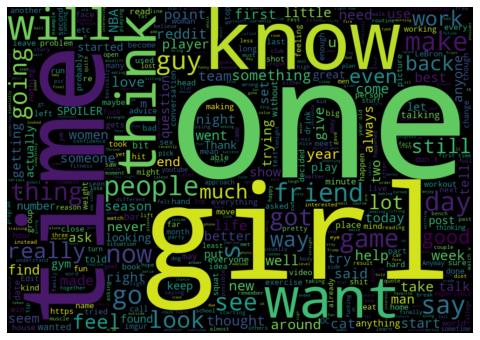

In [19]:
# Plot the positive Word Cloud
pos_df = dataset[dataset['Suicidal'] == 'No']
positive_text = ' '.join([comnt for comnt in pos_df['Sentence']])

WC=WordCloud(width=1000,height=700,max_words=500,min_font_size=5)
positive_words=WC.generate(positive_text)

fig = plt.figure(1, figsize=(10, 6))
plt.imshow(positive_words, interpolation = "bilinear")
plt.axis('off')
plt.show()

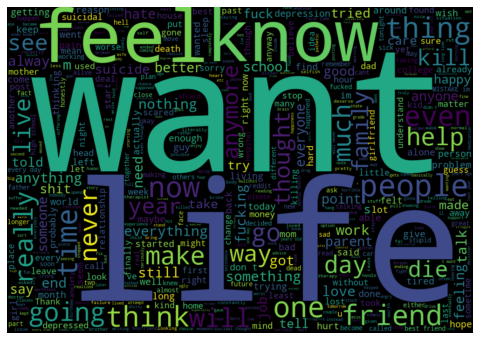

In [20]:
# Plot the negative Word Cloud
neg_df = dataset[dataset['Suicidal'] == 'Yes']
negative_text = ' '.join([comnt for comnt in neg_df['Sentence']])

WC=WordCloud(width=1000,height=700,max_words=500,min_font_size=5)
negative_words=WC.generate(negative_text)

fig = plt.figure(1, figsize=(10, 6))
plt.imshow(negative_words, interpolation = "bilinear")
plt.axis('off')
plt.show()

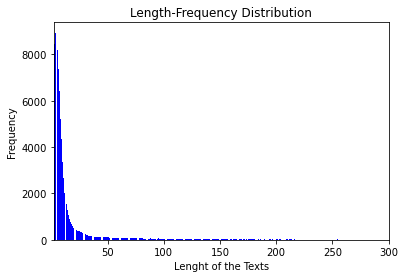

Maximum Length of a Text: 3221
Minimum Length of a Text: 1
Average Length of a Text: 23.0


In [21]:
# Calculate the Text of each of the Text
dataset['TextLength'] = dataset.cleaned.apply(lambda x:len(x.split()))
frequency = dict()
for i in dataset.TextLength:
    frequency[i] = frequency.get(i, 0)+1

plt.bar(frequency.keys(), frequency.values(), color ="b")
plt.xlim(2, 300)
plt.xlabel('Lenght of the Texts')
plt.ylabel('Frequency')
plt.title('Length-Frequency Distribution')
plt.show()  
print(f"Maximum Length of a Text: {max(dataset.TextLength)}")
print(f"Minimum Length of a Text: {min(dataset.TextLength)}")
print(f"Average Length of a Text: {round(np.mean(dataset.TextLength),0)}")

In [22]:
texts = dataset['cleaned'].values
labels = dataset['Suicidal'].values
encoder = LabelEncoder()
encoded_labels = encoder.fit_transform(labels)

In [23]:
X_train, X_test, y_train, y_test = train_test_split(texts, encoded_labels,test_size = 0.2, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(69604,) (17402,) (69604,) (17402,)


In [24]:
vocab_size = 30000
embedding_dim = 500
max_length = 3221
trunc_type = 'post'
padding_type = 'post'

In [25]:
#Tokenization
tokenizer = Tokenizer(num_words = vocab_size, split = (' '))
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index

In [26]:
#Padding

X_train = tokenizer.texts_to_sequences(X_train)
X_train_padded = pad_sequences(X_train, padding='post', maxlen=max_length)

X_test = tokenizer.texts_to_sequences(X_test)
X_test_padded = pad_sequences(X_test, padding='post', maxlen=max_length)

In [27]:
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
model.add(layers.Conv1D(128, 5, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(10, activation='relu'))
model.add(Dense(1, activation = 'sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 3221, 500)         15000000  
_________________________________________________________________
conv1d (Conv1D)              (None, 3217, 128)         320128    
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 10)                1290      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 15,321,429
Trainable params: 15,321,429
Non-trainable params: 0
_________________________________________________________________


In [28]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

history = model.fit(X_train_padded, 
                    y_train, epochs=10, 
                    verbose=1,
                    steps_per_epoch = len(X_train)/256,
                    batch_size = 32,
                    validation_split=0.2)

Epoch 1/10
271/271 [==============================] - 50s 162ms/step - loss: 0.2137 - accuracy: 0.9335 - val_loss: 0.1218 - val_accuracy: 0.9592
Epoch 2/10
271/271 [==============================] - 42s 155ms/step - loss: 0.1277 - accuracy: 0.9565 - val_loss: 0.1089 - val_accuracy: 0.9615
Epoch 3/10
271/271 [==============================] - 45s 165ms/step - loss: 0.1124 - accuracy: 0.9619 - val_loss: 0.1024 - val_accuracy: 0.9662
Epoch 4/10
271/271 [==============================] - 45s 164ms/step - loss: 0.1047 - accuracy: 0.9624 - val_loss: 0.0986 - val_accuracy: 0.9663
Epoch 5/10
271/271 [==============================] - 44s 163ms/step - loss: 0.1042 - accuracy: 0.9654 - val_loss: 0.0950 - val_accuracy: 0.9675
Epoch 6/10
271/271 [==============================] - 45s 166ms/step - loss: 0.1101 - accuracy: 0.9607 - val_loss: 0.0951 - val_accuracy: 0.9677
Epoch 7/10
271/271 [==============================] - 47s 174ms/step - loss: 0.0789 - accuracy: 0.9693 - val_loss: 0.0992 - val_ac

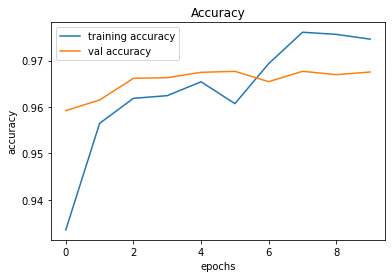

In [29]:
plt.figure(0)
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

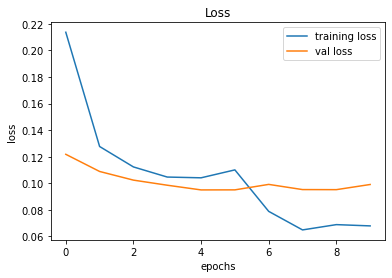

In [30]:
plt.figure(1)
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [31]:
prediction = model.predict(X_test_padded)
# Get labels based on probability 1 if p>= 0.5 else 0
y_pred = []
for i in prediction:
    if i >= 0.5:
        y_pred.append(1)
    else:
        y_pred.append(0)
        
print("Accuracy of prediction on test set : ", accuracy_score(y_test,y_pred))

Accuracy of prediction on test set :  0.9615561429720721


In [32]:
class_names = ['suicide','non-suicide']

In [33]:
cf = classification_report(y_test,y_pred, target_names = class_names)
print(cf)

              precision    recall  f1-score   support

     suicide       0.97      0.99      0.98     16032
 non-suicide       0.83      0.64      0.72      1370

    accuracy                           0.96     17402
   macro avg       0.90      0.82      0.85     17402
weighted avg       0.96      0.96      0.96     17402



In [34]:
cm = confusion_matrix(y_test,y_pred)

cm_df = pd.DataFrame(cm, index = class_names,
                     columns = class_names
                    )

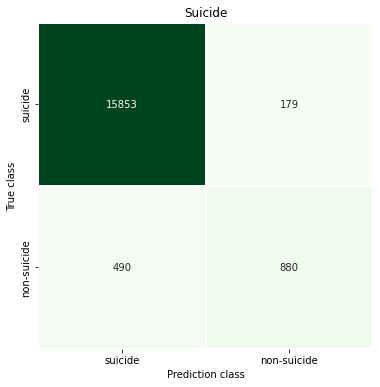

In [35]:
plt.figure(figsize = (6,6))
sns.heatmap(cm_df, annot = True,cmap='Greens',cbar=False,linewidth=2,fmt='d')
plt.title('Suicide')
plt.ylabel('True class')
plt.xlabel('Prediction class')
plt.show()